In [2]:
# 导入
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn as sklearn
from PIL import Image

import random
import re

from concurrent.futures import ThreadPoolExecutor
import queue

%matplotlib inline

In [2]:
# 公共常量

DEBUG = False
# 开发模式? 不修改代码并调试的话那设置这个为 False 即可


In [3]:
# 工具函数

def gen_layer_name(where, role, num):
    # 此函数用于生成层的名字
    
    _layer_name = "{}_{}_{}".format(where, num, role)
    
    if DEBUG:
        _layer_name = "{}_{}".format(_layer_name, random.randint(0, 100000000))
        
    return _layer_name


def target_to_vector(target):
    """
    一共七种可能的取值:
        0. Earthquake
        1. Fire
        2. Flood
        3. Hurricane
        4. Landslide
        5. Other disaster
        6. Not disaster
    :return: np.array
    """

    targets_index = {
        "earthquake": 0,
        "fire": 1,
        "flood": 2,
        "hurricane": 3,
        "landslide": 4,
        "other_disaster": 5,
        "not_disaster": 6
    }

    vec = np.array([0, 0, 0, 0, 0, 0, 0])
    vec[targets_index[target]] = 1

    return vec


def vector_to_target(vec):
    targets = [
        "earthquake",
        "fire",
        "flood",
        "hurricane",
        "landslide",
        "other_disaster",
        "not_disaster"
    ]

    return targets[np.argmax(vec)]



In [ ]:
# 测试工具函数


In [4]:
# 数据预处理函数

def pre_process_data_none(data):
    # 不进行任何处理的预处理函数
    return data


def pre_process_data_filtered(data):
    # 删除 informative 为 not_informative 的数据
    # 删除 damage_severity 为 little_or_none 的数据
    
    d = data.groupby(["informative"]).get_group("informative")

    mild = d.groupby("damage_severity").get_group("mild")
    severe = d.groupby("damage_severity").get_group("severe")
    
    d = pd.concat([mild, severe])
    d = d.sample(frac=1).reset_index(drop=True)
    
    return d


def gen_data_function(img_data):
    # 接收一个 PIL 图像对象 返回一个五元组
    # 分别是 原始图像, 逆时针旋转 90 度, 逆时针旋转 180 度, 逆时针旋转 270 度, 镜像反转后的图像数据
    # 这些图像数据都是 ndarr 格式的
    
    original_img = img_data
    rotate_90 = img_data.rotate(90, expand=True)
    rotate_180 = img_data.rotate(180, expand=True)
    rotate_270 = img_data.rotate(270, expand=True)
    transpose = img_data.transpose(Image.FLIP_LEFT_RIGHT)
    
    return (
        np.asarray(original_img),
        np.asarray(rotate_90),
        np.asarray(rotate_180),
        np.asarray(rotate_270),
        np.asarray(transpose)
    )

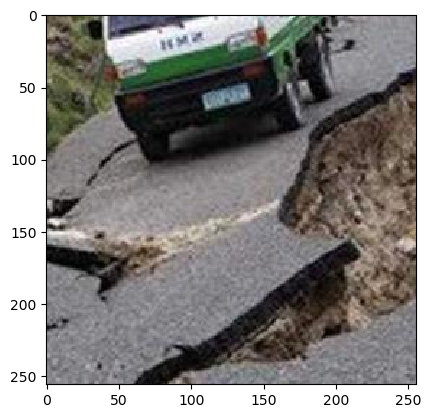

In [12]:
# 测试数据预处理函数

i = Image.open(f"./Data/available/data/ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_30256.jpg")

a, b, c, d, e = gen_data_function(i)

plt.imshow(e)


In [5]:
# 定义加载数据的函数

def data_reader(data_type="train", pre_process_func=None, gen_data_function=None):
    batch_size = 10
    start_index = 0

    # 存储多线程读取的数据的队列
    data_queue = queue.Queue(2)

    # 多线程读取数据
    pool = ThreadPoolExecutor(max_workers=1)
    future = None

    _csvs = {
        "train": "MEDIC_train.tsv",
        "test": "MEDIC_test.tsv",
        "dev": "MEDIC_dev.tsv"
    }

    # 把所有数据都读入
    csv = pd.read_csv(f"./Data/original/{_csvs[data_type]}", sep="\t", header=0)

    if pre_process_func:
        csv = pre_process_func(csv)

#     all_image_paths, all_targets = csv["image_path"], csv["disaster_types"]
#     data_len = len(all_image_paths)


    def _read_data(q):
        # 读取数据 这个函数将在读取数据的线程中运行
        # q 即为队列对象

        nonlocal batch_size
        nonlocal start_index
        nonlocal csv
#         nonlocal all_image_paths
#         nonlocal all_targets
#         nonlocal data_len

        all_image_paths, all_targets = csv["image_path"], csv["disaster_types"]
        data_len = len(all_image_paths)

        # 准备存储数据的矩阵
        data_x = np.empty((0, 256, 256))
        data_y = np.empty((0, 7))

        data_dir = "./Data/available/"

        # 从预读入的数据中切取数据
        image_paths = all_image_paths[start_index: start_index + batch_size]
        targets = all_targets[start_index: start_index + batch_size]

        image_paths = image_paths.reset_index(drop=True)
        targets = targets.reset_index(drop=True)

        for image_index in range(len(image_paths)):
            image_path = image_paths[image_index]
            image_path = image_path.split(".")[0] + ".jpg"

            img = Image.open(data_dir + image_path)

            if gen_data_function:
                gened_data = gen_data_function(img)
                img = list(gened_data)

                img = [im.mean(axis=-1) for im in img]
            else:
                img = [np.asarray(img).mean(axis=-1)]

            for im in img:
                data_x = np.concatenate([data_x, im[np.newaxis, :, :]])

                target = targets[image_index]
                vector_target = target_to_vector(target)
                data_y = np.concatenate([data_y, vector_target[np.newaxis, :]])

        # 数据处理好后放到队列中
        q.put((data_x, data_y))

        # 如果数据都取完了就从头开始继续取
        if start_index + batch_size >= data_len:
            print("--- all data trained  now restart ---")
            start_index = 0
            
            # 乱序训练数据
            csv = csv.sample(frac=1).reset_index(drop=True)
        else:
            start_index += batch_size

        return


    def _get_a_data():
        # 读取数据并控制读取线程的运行

        nonlocal future
        nonlocal data_queue
        nonlocal _read_data

        if data_queue.empty():
            # 当队列为空的时候有两种可能 要么线程已经开启 要么线程就没开

            if future is not None and future.running():
                # 当线程已经开启的时候 就直接阻塞等待即可
                while not future.done():
                    pass
            else:
                # 如果线程没开的话就开一个线程
                future = pool.submit(_read_data, data_queue)

            # 等待现有线程运行结束
            # 如果 "线程已经开启" 下的阻塞已经完成的话 那这里的阻塞就不会运行
            while not future.done():
                pass

            # 获取数据
            data = data_queue.get()

            # 然后继续新开一个线程即可
            future = pool.submit(_read_data, data_queue)

            return data

        # 队列不为空 直接取出数据返回即可
        data = data_queue.get()

        # 新开一个线程继续处理数据
        future = pool.submit(_read_data, data_queue)

        return data


    def _shutdown_pool():
        # 关闭线程池
        nonlocal pool

        pool.shutdown()
        return

    return _get_a_data, _shutdown_pool


next_batch_train_data, shutdown_pool = data_reader(pre_process_func = pre_process_data_filtered, gen_data_function=gen_data_function)

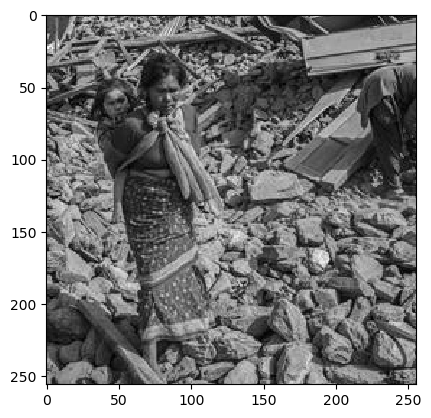

In [7]:
# 测试加载的数据
# *** 如果不需要测试加载的数据 那此格子就不必运行!!! ***

X, Y = next_batch_train_data()

# shutdown_pool()

[1. 0. 0. 0. 0. 0. 0.]
earthquake


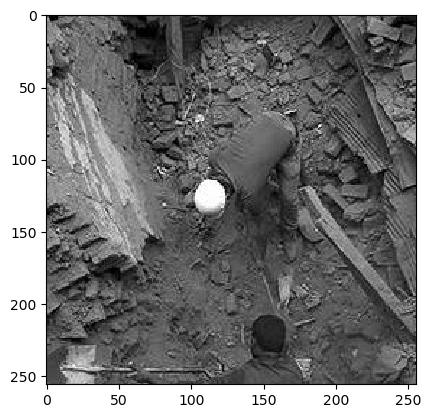

In [16]:
# 测试加载的数据
# *** 如果不需要测试加载的数据 那此格子就不必运行!!! ***

i = 5

plt.imshow(X[i], cmap=plt.cm.gray)

print(Y[i])

print( vector_to_target(Y[i]) )


In [17]:
# 测试加载的数据
# *** 如果不需要测试加载的数据 那此格子就不必运行!!! ***


shutdown_pool()

In [6]:
# 生成神经网络层的函数

def gen_conv_layer(
    data,
    in_channels,
    out_channels,
    layer_No,
    filter_width = 3,
    conv_strides=[1, 1, 1, 1],
    pool_size = [1, 2, 2, 1],
    pool_strides = [1, 2, 2, 1],
    keep_prob = 0.6
):
    # 生成卷积层
    # data: 被卷积的数字
    # in_channels  输入的数据的通道数
    # out_channels  输出的数据的通道数(即输出几个数据)
    # layer_No  层编号
    # filter_width  卷积核宽度 默认卷积核高度和宽度相同
    # conv_strides  卷积步幅
    # pool_size  池化核大小
    # pool_strides  池化步幅
    # keep_prob  在随机丢弃神经元操作中 每个神经元被保留下来的概率
    
    filter_ = tf.get_variable(
        gen_layer_name("convlayer", "filter", layer_No), 
        shape=[filter_width, filter_width, in_channels, out_channels], 
        dtype=np.float64, 
        initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float64)
    )

    b = tf.get_variable(
        gen_layer_name("convlayer", "bias", layer_No), 
        shape=[out_channels], 
        dtype=np.float64, 
        initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float64)
    )

    conv = tf.nn.conv2d(
        input=data,
        filter=filter_,
        strides=conv_strides,
        padding="SAME"
    )
    
    conv = tf.nn.bias_add(conv, b)

    relu = tf.nn.relu(conv)
    
    maxpool = tf.nn.max_pool(
        relu,
        ksize=pool_size,
        strides=pool_strides,
        padding="SAME"
    )
    
    return maxpool


def gen_fc_layer(
    data,
    in_size,
    out_size,
    layer_No,
    use_dropout=True,
    use_bais=True,
    keep_prob = 0.6
):
    # 生成全连接层的函数
    # data  输入数据数
    # in_size  输出神经元个数
    # out_size  输出神经元个数
    # layer_No  神经元层编号
    # use_dropout  是否随机丢弃某些神经元以防止过拟合
    # use_bais  是否添加偏置
    # keep_prob  在随机丢弃神经元操作中 每个神经元被保留下来的概率
    
    w = tf.get_variable(
        gen_layer_name("fc", "w", layer_No), 
        shape=[in_size, out_size], 
        dtype=np.float64, 
        initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float64)
    )
    
    b = tf.get_variable(
        gen_layer_name("fc", "b", layer_No), 
        shape=[out_size], 
        dtype=np.float64, 
        initializer=tf.contrib.layers.variance_scaling_initializer(dtype=tf.float64)
    )

    fc = tf.matmul(
        tf.reshape(
            data,
            shape=[-1, in_size]
        ),
        w
    )
    
    if use_bais:
        fc = tf.nn.bias_add(fc, b)
    
    if use_dropout:
        fc = tf.nn.dropout(
            fc,
            keep_prob=keep_prob
        )
    
    return fc

In [52]:
# 测试生成神经网络层的函数


In [68]:
'''
    这里的卷积神经网络的结构如下:
    输入层 - 五层卷积 - 三层全连接 - 输出
    共 10 层
    
    
    具体结构如下:
    输入层
        将输入的 256 * 256 的数据展平 变为输入 256*256 = 65536 个数据
        
        
    卷积层
        3*3 卷积核 共 8 组 每组 1 个 填充 得到 8 个 256*256 的卷积结果
        添加偏置
        ReLU 处理
        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 8 个 128*128 的卷积结果
        
    
    卷积层
        3*3 卷积核 共 16 组 每组 8 个 填充 得到 16 个 128*128 的卷积结果
        添加偏置
        ReLU 处理
        最大值池化 窗口 2*2  步幅为 [2, 2]  得到16 个 64*64 的卷积结果
        
        
    卷积层
        3*3 卷积核 共 32 组 每组 16 个 填充 得到 32 个 64*64 的卷积结果
        添加偏置
        ReLU 处理
        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 32 个 32 * 32 的卷积结果
    
    
    卷积层
        3*3 卷积核 共 64 组 每组 32 个 填充 得到 64 个 32*32 的卷积结果
        添加偏置
        ReLU 处理
        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 64 个 16*16 的卷积结果
        
        
    卷积层
        3*3 卷积核 共 64 组 每组 64 个 填充 得到 64 个 16*16 的卷积结果
        添加偏置
        ReLU 处理
        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 64 个 8*8 的卷积结果

        
    全连接层
        输入 8*8*64=4096 个数据 输出 2048
        添加偏置
        ReLU 处理
        dropout
        
    
    全连接层
        输入 2048 个数据 输出 512
        添加偏置
        ReLU 处理
        dropout
        
    
    全连接层
        输入 512 个数据 输出 128
        添加偏置
        ReLU 处理
        dropout
        
    
    输出层
        输入 128 个数据 输出 7
        softmax 处理
'''

'\n    这里的卷积神经网络的结构如下:\n    输入层 - 三层卷积 - 两层全连接 - 输出\n    共 7 层\n    \n    \n    具体结构如下:\n    输入层\n        将输入的 28*28 的数据展平 变为输入 28*28 = 784 个数据\n        \n        \n    卷积层\n        3*3 卷积核 共 8 组 每组 1 个 填充 得到 8 个 28*28 的卷积结果\n        添加偏置\n        ReLU 处理\n        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 8 个 14*14 的卷积结果\n        \n    \n    卷积层\n        3*3 卷积核 共 16 组 每组 8 个 填充 得到 16 个 14*14 的卷积结果\n        添加偏置\n        ReLU 处理\n        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 32 个 7*7 的卷积结果\n        \n        \n    卷积层\n        3*3 卷积核 共 32 组 每组 16 个 填充 得到 32 个 7*7 的卷积结果\n        添加偏置\n        ReLU 处理\n        最大值池化 窗口 2*2  步幅为 [2, 2]  得到 32 个 4*4 的卷积结果\n        \n    全连接层\n        输入 4*4*32=512 个数据 输出 256\n        添加偏置\n        ReLU 处理\n        dropout\n        \n    \n    全连接层\n        输入 256 个数据 输出 128\n        添加偏置\n        ReLU 处理\n        dropout\n        \n    \n    输出层\n        输入 128 个数据 输出 10\n        softmax 处理\n'

In [7]:
# 声明模型

with tf.device("/gpu:0"):
    
    with tf.name_scope("placeholder") as scope:
        X = tf.placeholder(
            shape = [None, 256, 256, 1],
            dtype = tf.float64
        )

        Y = tf.placeholder(
            shape=[None, 7],
            dtype=tf.float64
        )


    with tf.name_scope("convlayer_1") as scope:
        conv1 = gen_conv_layer(X, 1, 8, layer_No=1)


    with tf.name_scope("convlayer_2") as scope:
        conv2 = gen_conv_layer(conv1, 8, 16, layer_No=2)


    with tf.name_scope("convlayer_3") as scope:
        conv3 = gen_conv_layer(conv2, 16, 32, layer_No=3)
        
        
    with tf.name_scope("convlayer_4") as scope:
        conv4 = gen_conv_layer(conv3, 32, 64, layer_No=4)
        
        
    with tf.name_scope("convlayer_5") as scope:
        conv5 = gen_conv_layer(conv4, 64, 64, layer_No=5)


    with tf.name_scope("fc_1") as scope:
        fc1 = gen_fc_layer(
            tf.reshape(conv5, shape=[-1, 8*8*64]),
            8*8*64,
            2048,
            layer_No=6
        )


    with tf.name_scope("fc_2") as scope:
        fc2 = gen_fc_layer(fc1, 2048, 512, layer_No=7)
        
        
    with tf.name_scope("fc_3") as scope:
        fc3 = gen_fc_layer(fc2, 512, 128, layer_No=8)


    with tf.name_scope("out") as scope:
        out = gen_fc_layer(fc3, 128, 7, layer_No=9, use_dropout=False, use_bais=False)
        # out  <tf.Tensor 'out/MatMul:0' shape=(?, 7) dtype=float64>




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
# 损失和优化

cost = tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=out,
    labels=Y
)
# 交叉熵

cost = tf.reduce_mean(cost)
# 交叉熵的平均值即为损失

op = tf.train.AdamOptimizer().minimize(cost)
# 使用 Adam 优化方法让损失最小


In [9]:
# 保存器 以及其他的一些需要的东西

gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction = 0.8
)
# 设置使用 GPU  并设置最多可以使用 GPU 的 80% 的内存

config = tf.ConfigProto(
    allow_soft_placement = True,
    # log_device_placement = True,
    gpu_options = gpu_options
)
# 生成配置对象: 允许使用 GPU  允许 tensorflow 自行根据情况使用设备
# 关闭输出日志 日志输出久了容易拖慢运行速度

saver = tf.train.Saver()
# 保存器 用于保存模型

In [10]:
# 训练

costs = []
accs = []
marco_precisions = []
marco_recalls = []
marco_f_measures = []
micro_f_measures = []
kappas = []
# 暂存数据的列表


with tf.Session(config=config) as sess:
    
    if os.listdir("./Model"):
        # 如果存在训练过的模型 就加载训练过的模型然后继续训练
        
        models = os.listdir("./Model")

        models = [i.split(".")[0] for i in models]

        models = set(models)

        models = [
            (
                int(re.findall(r"[a-zA-Z-_]+(\d+)", i)[0]),
                i
            )
            for i in models
            if i != "checkpoint"
        ]

        models = sorted(models, key=lambda x: x[0])

        saver.restore(sess, save_path="./Model/" + models[-1][-1])
    else:
        # 否则就初始化全局变量即可
        sess.run( tf.global_variables_initializer() )
        # 初始化全局变量
    
    train_count = 0
    # 训练计数器
    
#     while acc < 0.9:
#     while train_count < 20001:
    while True:
        Xtrain, Ytrain = next_batch_train_data()
        # 获取训练数据
    
        op_, cost_, pred = sess.run(
            fetches = [op, cost, out],
            feed_dict = {
                X: Xtrain.reshape(-1, 256, 256, 1),
                Y: Ytrain
            }
        )
        # 执行优化操作 这一步就是训练
        # cost_ 是个数字  pred 是个 ndarr

        acc = tf.reduce_mean(
            tf.cast(
                tf.equal(
                    tf.argmax(pred, axis=-1),
                    tf.argmax(Ytrain, axis=-1)
                ),
                dtype=np.float64
            )
        )
        # 计算准确率
        # acc 是个 tf op
        
        
        if train_count % 50 == 0:
            # 每 50 次看一下准确率信息
            accval = sess.run(acc)
            
            print("count: {}  loss: {}  acc: {}".format(train_count, cost_, accval))
        
        
        if train_count % 10 == 0:
            # 每 10 次训练暂存准确率信息
            
            accval = sess.run(acc)
            
            costs.append( cost_ )
            accs.append( accval )

            Ytrain = np.argmax(Ytrain, axis=-1)
            pred = np.argmax(pred, axis=-1)
            
            marco_precisions.append(
                sklearn.metrics.precision_score(Ytrain, pred, average="macro")
            )
            
            marco_recalls.append(
                sklearn.metrics.recall_score(Ytrain, pred, average="macro")
            )
            
            marco_f_measures.append(
                sklearn.metrics.f1_score(Ytrain, pred, average="macro")
            )
            
            micro_f_measures.append(
                sklearn.metrics.f1_score(Ytrain, pred, average="micro")
            )
            
            kappas.append(
                sklearn.metrics.cohen_kappa_score(Ytrain, pred)
            )
        
        
        if len(accs) == 100:
            # 保存准确率数据到硬盘 而后清空暂存数据
            # 这样一来就是每 10 * 100 = 1000 次训练就向硬盘保存一次信息
            
            np.save(
                "./Log/Accs/Accs_{}".format(train_count), 
                np.array(accs)
            )
            
            np.save(
                "./Log/Costs/Costs_{}".format(train_count), 
                np.array(costs)
            )
            
            np.save(
                "./Log/Marco_precisions/Marco_precisions_{}".format(train_count), 
                np.array(marco_precisions)
            )
            
            np.save(
                "./Log/Marco_recalls/Marco_recalls_{}".format(train_count),
                np.array(marco_recalls)
            )
            
            np.save(
                "./Log/Marco_f_measures/Marco_f_measures_{}".format(train_count),
                np.array(marco_f_measures)
            )
            
            np.save(
                "./Log/Micro_f_measures/Micro_f_measures_{}".format(train_count),
                np.array(micro_f_measures)
            )
            
            np.save(
                "./Log/Kappas/Kappas_{}".format(train_count), 
                np.array(kappas)
            )
            
            accs.clear()
            costs.clear()
            marco_precisions.clear()
            marco_recalls.clear()
            marco_f_measures.clear()
            micro_f_measures.clear()
            kappas.clear()
            # 保存完后就清空列表即可
        
        
        if train_count % 1000 == 0 and train_count != 0:
            # 每训练 1000 次保存一下模型
            saver.save(sess, save_path="./Model/image_classifcation_model", global_step=train_count)
        
        
        train_count += 1

count: 0  loss: 1640.678063289381  acc: 0.14


D:\proj\python\CNN_image_classification\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\proj\python\CNN_image_classification\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


count: 50  loss: 1.6715590118808783  acc: 0.5
count: 100  loss: 1.2183016146190357  acc: 0.66
count: 150  loss: 1.1835192814450044  acc: 0.8
count: 200  loss: 1.151244292956517  acc: 0.7
count: 250  loss: 1.5260460744127942  acc: 0.5
count: 300  loss: 1.448768980803456  acc: 0.6
count: 350  loss: 1.6217350287287275  acc: 0.5
count: 400  loss: 1.5398045045086086  acc: 0.5


KeyboardInterrupt: 

""" 训练完记得运行: """
shutdown_pool()

In [12]:
# 预测
next_batch_test_data, shutdown_pool = data_reader()


with tf.Session(config=config) as sess:
    saver.restore(sess, save_path="./Model_done/image_classifcation_model-2000")
    
    Xtest, Ytest = next_batch_test_data()
    
    pred = sess.run(
        out,
        feed_dict = {
            X: Xtest.reshape(-1, 28, 28, 1)
        }
    )
    
    pred = sess.run( tf.argmax(pred, axis=-1) )
    real = sess.run( tf.argmax(Ytest, axis=-1) )
    
    acc = tf.reduce_mean(
        tf.cast(
            tf.equal(pred, real),
            dtype=np.float64
        )
    )
    
    
    print("acc: {}".format( sess.run(acc) ))
    
    
    for i in range( len(pred) ):
        print("real: {}  pred: {}".format(real[i], pred[i]))
        

shutdown_pool()

INFO:tensorflow:Restoring parameters from ./Model_done/image_classifcation_model-2000


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key convlayer_1_bias_50177365 not found in checkpoint
	 [[node save/RestoreV2 (defined at C:\Users\cinic\AppData\Local\Temp\ipykernel_13756\2189689611.py:13) ]]
	 [[node save/RestoreV2 (defined at C:\Users\cinic\AppData\Local\Temp\ipykernel_13756\2189689611.py:13) ]]

Caused by op 'save/RestoreV2', defined at:
  File "C:\python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\proj\python\CNN_image_classification\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "C:\python37\lib\asyncio\base_events.py", line 523, in run_forever
    self._run_once()
  File "C:\python37\lib\asyncio\base_events.py", line 1758, in _run_once
    handle._run()
  File "C:\python37\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
    await result
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
    cell_id=cell_id,
  File "D:\proj\python\CNN_image_classification\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
    raw_cell, store_history, silent, shell_futures, cell_id
  File "D:\proj\python\CNN_image_classification\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
    return runner(coro)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
    coro.send(None)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "D:\proj\python\CNN_image_classification\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\cinic\AppData\Local\Temp\ipykernel_13756\2189689611.py", line 13, in <module>
    saver = tf.train.Saver()
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\training\saver.py", line 832, in __init__
    self.build()
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\training\saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\training\saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\training\saver.py", line 513, in _build_internal
    restore_sequentially, reshape)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\training\saver.py", line 332, in _AddRestoreOps
    restore_sequentially)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\training\saver.py", line 580, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1656, in restore_v2
    name=name)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "D:\proj\python\CNN_image_classification\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key convlayer_1_bias_50177365 not found in checkpoint
	 [[node save/RestoreV2 (defined at C:\Users\cinic\AppData\Local\Temp\ipykernel_13756\2189689611.py:13) ]]
	 [[node save/RestoreV2 (defined at C:\Users\cinic\AppData\Local\Temp\ipykernel_13756\2189689611.py:13) ]]


In [3]:
# 读取训练信息 - 精确率, 召回率, 准确率, marco-f-measure, micro-f-measure

_train_info_dict = {
    "Accs": np.array([]),
    "Costs": np.array([]),
    "Kappas": np.array([]),
    "Marco_f_measures": np.array([]),
    "Marco_precisions": np.array([]),
    "Marco_recalls": np.array([]),
    "Micro_f_measures": np.array([])
}

for floder_name in ["Accs", "Costs", "Kappas", "Marco_f_measures", "Marco_precisions", "Marco_recalls", "Micro_f_measures"]:
    file_names = os.listdir("./Log/" + "/" + floder_name)
    # 读取保存的数据
    
    file_names = [
        ( int(re.findall(r'\w+?(\d+).npy', name)[0]), name ) for name in file_names
    ]
    # 发现读入的顺序不是数据保存时的数据 先将文件名列表中的元素变为 (保存编号, 文件名)
    
    file_names = sorted(file_names, key=lambda x: x[0])
    #  依据保存编号将文件名按保存顺序重新排列
    
    file_names = [name[1] for name in file_names]
    # 排列完后的文件名列表
    
    for file_name in file_names:
        # 按排列完后的文件名顺序读入数据
        _arr = np.load("./Log/" + "/" + floder_name + "/" + file_name)
        
        _train_info_dict[floder_name] = np.append(_train_info_dict[floder_name], _arr)
        
        print(file_name)

for key in _train_info_dict:
    print("{}  shape: {}".format(key, _train_info_dict[key].shape))

Accs_990.npy
Accs_1990.npy
Accs_2990.npy
Costs_990.npy
Costs_1990.npy
Costs_2990.npy
Kappas_990.npy
Kappas_1990.npy
Kappas_2990.npy
Marco_f_measures_990.npy
Marco_f_measures_1990.npy
Marco_f_measures_2990.npy
Marco_precisions_990.npy
Marco_precisions_1990.npy
Marco_precisions_2990.npy
Marco_recalls_990.npy
Marco_recalls_1990.npy
Marco_recalls_2990.npy
Micro_f_measures_990.npy
Micro_f_measures_1990.npy
Micro_f_measures_2990.npy
Accs  shape: (300,)
Costs  shape: (300,)
Kappas  shape: (300,)
Marco_f_measures  shape: (300,)
Marco_precisions  shape: (300,)
Marco_recalls  shape: (300,)
Micro_f_measures  shape: (300,)


0.4


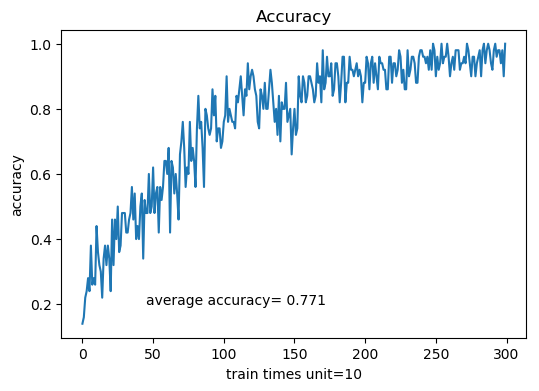

In [4]:
# 可视化 - 准确率

x = _train_info_dict["Accs"].shape[0]
x = np.linspace(0, x-1, x)
y = _train_info_dict["Accs"]

plt.figure(figsize=(6, 4))

plt.title("Accuracy")

plt.annotate(
    s="average accuracy= %.3f" % y.mean(),
    xy=(1, 0.2),
    xytext=(45, 0.2),
)

plt.xlabel("train times unit=10")
plt.ylabel("accuracy")

plt.plot(x, y)

print(y[40])

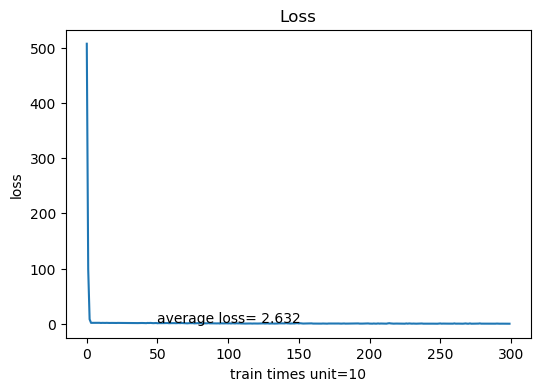

In [5]:
# 可视化 - 损失

x = _train_info_dict["Costs"].shape[0]
x = np.linspace(0, x-1, x)
y = _train_info_dict["Costs"]

plt.figure(figsize=(6, 4))

plt.title("Loss")

plt.annotate(
    s="average loss= %.3f" % y.mean(),
    xy=(50, 0.3),
    xytext=(50, 2),
)

plt.xlabel("train times unit=10")
plt.ylabel("loss")

plt.plot(x, y)


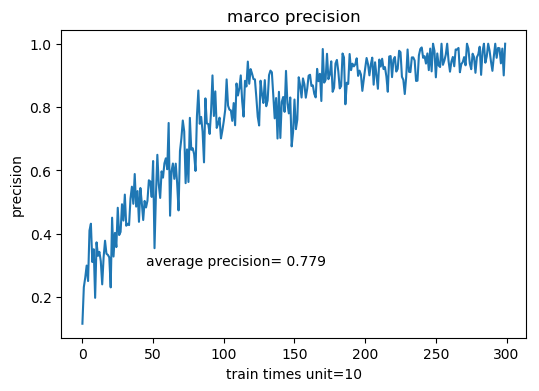

In [6]:
# 可视化 - 精确率

x = _train_info_dict["Marco_precisions"].shape[0]
x = np.linspace(0, x-1, x)
y = _train_info_dict["Marco_precisions"]

plt.figure(figsize=(6, 4))

plt.title("marco precision")

plt.annotate(
    s="average precision= %.3f" % y.mean(),
    xy=(50, 0.2),
    xytext=(45, 0.3),
)

plt.xlabel("train times unit=10")
plt.ylabel("precision")

plt.plot(x, y)


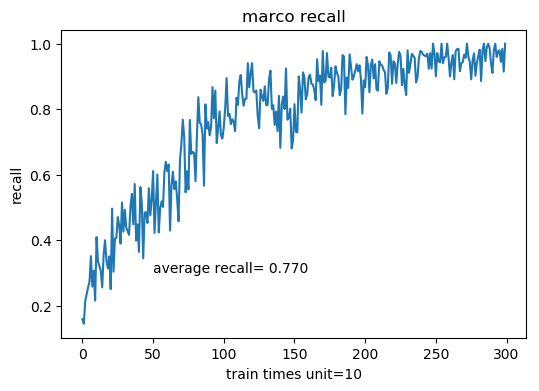

In [7]:
# 可视化 - 召回率

x = _train_info_dict["Marco_recalls"].shape[0]
x = np.linspace(0, x-1, x)
y = _train_info_dict["Marco_recalls"]

plt.figure(figsize=(6, 4))

plt.title("marco recall")

plt.annotate(
    s="average recall= %.3f" % y.mean(),
    xy=(50, 0.2),
    xytext=(50, 0.3),
)

plt.xlabel("train times unit=10")
plt.ylabel("recall")

plt.plot(x, y)


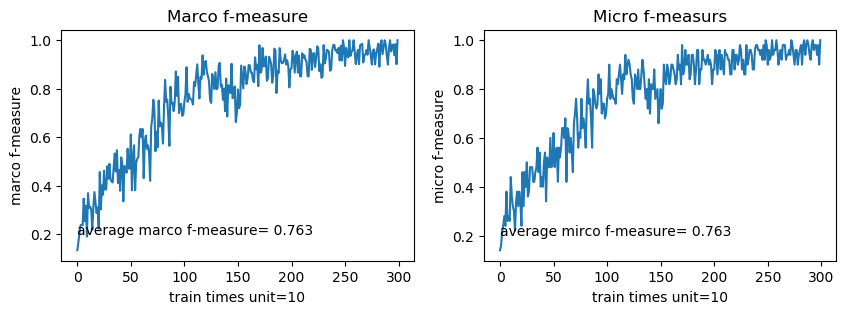

In [8]:
# 可视化 marco-f-measure 和 micro-f-measure

x = _train_info_dict["Marco_f_measures"].shape[0]
x = np.linspace(0, x-1, x)

y_marco = _train_info_dict["Marco_f_measures"]
y_micro = _train_info_dict["Micro_f_measures"]

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("Marco f-measure")

plt.annotate(
    s="average marco f-measure= %.3f" % y_marco.mean(),
    xy=(50, 0.2),
    xytext=(0, 0.2),
)

plt.xlabel("train times unit=10")
plt.ylabel("marco f-measure")

plt.plot(x, y_marco)


plt.subplot(1, 2, 2)
plt.title("Micro f-measurs")

plt.annotate(
    s="average mirco f-measure= %.3f" % y_marco.mean(),
    xy=(50, 0.2),
    xytext=(0, 0.2),
)

plt.xlabel("train times unit=10")
plt.ylabel("micro f-measure")

plt.plot(x, y_micro)


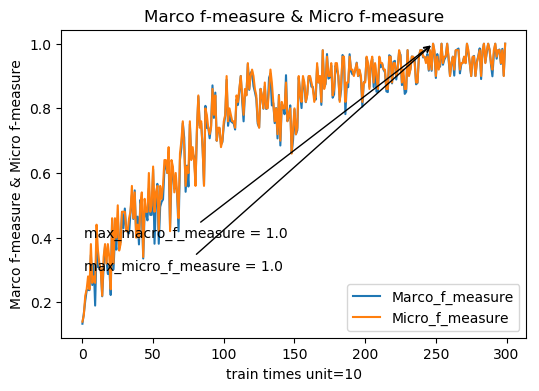

In [9]:
# 可视化 marco-f-measure 和 micro-f-measure 的对比
# 以及最大 marco-f-measure 和最大 micro-f-measure

x = _train_info_dict["Marco_f_measures"].shape[0]
x = np.linspace(0, x-1, x)

y_marco = _train_info_dict["Marco_f_measures"]
y_micro = _train_info_dict["Micro_f_measures"]

y_marco_max_index = np.argmax(y_marco)
y_micro_max_index = np.argmax(y_micro)

plt.figure(figsize=(6, 4))
plt.title("Marco f-measure & Micro f-measure")

plt.xlabel("train times unit=10")
plt.ylabel("Marco f-measure & Micro f-measure")

plt.plot(x, y_marco)
plt.plot(x, y_micro)

plt.annotate(
    s="max_macro_f_measure = {}".format( y_marco[y_marco_max_index] ),
    xy=(y_marco_max_index, y_marco[y_marco_max_index]),
    xytext=(1, 0.4),
    arrowprops={"arrowstyle": "->"}
)

plt.annotate(
    s="max_micro_f_measure = {}".format( y_marco[y_micro_max_index] ),
    xy=(y_micro_max_index, y_micro[y_micro_max_index]),
    xytext=(1, 0.3),
    arrowprops={"arrowstyle": "->"}
)

plt.legend(["Marco_f_measure", "Micro_f_measure"], loc=4)


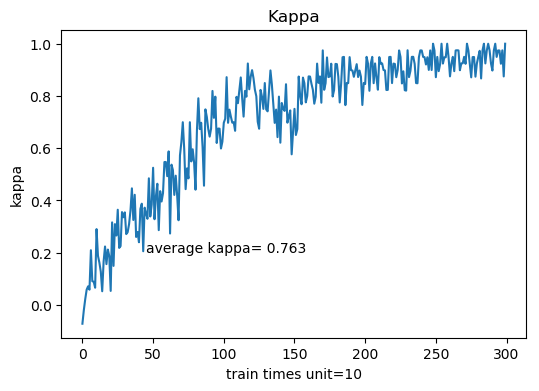

In [10]:
# 可视化 - Kappa 系数

x = _train_info_dict["Kappas"].shape[0]
x = np.linspace(0, x-1, x)
y = _train_info_dict["Kappas"]

plt.figure(figsize=(6, 4))

plt.title("Kappa")

plt.annotate(
    s="average kappa= %.3f" % y_marco.mean(),
    xy=(50, 0.2),
    xytext=(45, 0.2),
)

plt.xlabel("train times unit=10")
plt.ylabel("kappa")

plt.plot(x, y)
